# **Sistem Rekomendasi Buku Bacaan**

- **Nama:** Zid Irsyadin Sartono Wijaogy
- **Email:** zidirsyadin@gmail.com | a208yaf520@devacademy.id
- **ID Dicoding:** zid_isw

## **Perkenalan Dataset**

**GoodBooks-10k** adalah dataset yang berisi informasi tentang **10.000 buku** yang berbeda, termasuk rating yang diberikan oleh pengguna. Dataset ini digunakan untuk membangun sistem rekomendasi buku berbasis Collaborative Filtering. Terdapat beberapa file dalam dataset ini yang dapat digunakan untuk menganalisis data dan membuat model rekomendasi, seperti informasi tentang buku, rating yang diberikan oleh pengguna, serta tag yang digunakan untuk mengkategorikan buku-buku tersebut.

#### Tujuan Penggunaan Dataset
Dataset ini digunakan untuk membangun sistem rekomendasi berbasis **Collaborative Filtering**, di mana kita dapat memprediksi buku yang mungkin disukai oleh pengguna berdasarkan preferensi pengguna lain yang serupa. Dataset ini juga dapat digunakan untuk eksperimen dengan **Content-Based Filtering** jika ingin mengeksplorasi fitur buku seperti genre dan penulis untuk memberikan rekomendasi.

Unduh dataset **GoodBooks-10k** dari Kaggle melalui tautan [GoodBooks-10k Dataset](https://www.kaggle.com/datasets/zygmunt/goodbooks-10k)

---


## **Import Library**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from tabulate import tabulate
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


## **Data Loading**

In [2]:
ratings_df = pd.read_csv('ratings.csv')
books_df = pd.read_csv('books.csv')
tags_df = pd.read_csv('tags.csv')
to_read_df = pd.read_csv('to_read.csv')
book_tags_df = pd.read_csv('book_tags.csv')

In [3]:
print("Ratings DataFrame:")
ratings_df.head()

Ratings DataFrame:


,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [4]:
print("Books DataFrame:")
books_df.head()

Books DataFrame:


,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [5]:
print("Tags DataFrame:")
tags_df.head()

Tags DataFrame:


,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-


In [6]:
print("To Read DataFrame:")
to_read_df.head()

To Read DataFrame:


,user_id,book_id
0,1,112
1,1,235
2,1,533
3,1,1198
4,1,1874


In [7]:
print("Book Tags DataFrame:")
book_tags_df.head()

Book Tags DataFrame:


,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716


### Goodreads Dataset Overview

#### 1. Daftar Dataset

Berikut adalah daftar file dataset yang tersedia untuk proyek rekomendasi buku menggunakan pendekatan *Collaborative Filtering with Deep Learning*:

##### 1.1 `ratings.csv`
Berisi data interaksi pengguna dengan buku dalam bentuk rating (1–5).

| Kolom      | Tipe   | Deskripsi                          |
|------------|--------|------------------------------------|
| `user_id`  | int    | ID pengguna                        |
| `book_id`  | int    | ID buku                            |
| `rating`   | int    | Rating yang diberikan oleh user    |

---

##### 1.2 `books.csv`
Berisi metadata dari buku-buku yang tersedia.

| Kolom                     | Tipe     | Deskripsi                                |
|--------------------------|----------|------------------------------------------|
| `book_id`                | int      | ID unik buku                             |
| `title`                  | object   | Judul buku                               |
| `authors`                | object   | Nama penulis                             |
| `average_rating`         | float    | Rata-rata rating dari semua user         |
| `ratings_count`          | int      | Total jumlah rating yang diterima        |
| `image_url`              | object   | URL gambar sampul buku                   |
| ...                      | ...      | (masih banyak atribut pendukung lainnya) |

---

##### 1.3 `to_read.csv`
Berisi daftar buku yang ditandai pengguna untuk dibaca (tanpa rating).

| Kolom      | Tipe   | Deskripsi                      |
|------------|--------|--------------------------------|
| `user_id`  | int    | ID pengguna                    |
| `book_id`  | int    | ID buku                        |

---

##### 1.4 `tags.csv`
Berisi daftar semua tag yang mungkin digunakan untuk menandai buku.

| Kolom      | Tipe   | Deskripsi                      |
|------------|--------|--------------------------------|
| `tag_id`   | int    | ID unik tag                    |
| `tag_name` | object | Nama/tag                       |

---

##### 1.5 `book_tags.csv`
Berisi hubungan antara buku dan tag (berdasarkan jumlah pengguna yang menandainya).

| Kolom               | Tipe   | Deskripsi                                |
|---------------------|--------|------------------------------------------|
| `goodreads_book_id` | int    | ID buku (Goodreads)                      |
| `tag_id`            | int    | ID tag                                   |
| `count`             | int    | Jumlah pengguna yang menandai dengan tag |

---

## **Data Understanding**

### **Explorartory Data Analysis (EDA)** 

In [8]:
# Melihat informasi dari setiap DataFrame
dfs = {'ratings': ratings_df, 'books': books_df, 'tags': tags_df, 'to_read': to_read_df, 'book_tags': book_tags_df}
for name, df in dfs.items():
    print(f"--- {name.upper()} ---")
    print(df.info(), "\n")


--- RATINGS ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981756 entries, 0 to 981755
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   book_id  981756 non-null  int64
 1   user_id  981756 non-null  int64
 2   rating   981756 non-null  int64
dtypes: int64(3)
memory usage: 22.5 MB
None 

--- BOOKS ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         10000 non-null  int64  
 1   book_id                    10000 non-null  int64  
 2   best_book_id               10000 non-null  int64  
 3   work_id                    10000 non-null  int64  
 4   books_count                10000 non-null  int64  
 5   isbn                       9300 non-null   object 
 6   isbn13                     9415 non-null   float64
 7   authors     

In [9]:
# Mengecek missing values
for name, df in dfs.items():
    print(f"Missing values in {name.upper()}:")
    print(df.isnull().sum(), "\n")


Missing values in RATINGS:
book_id    0
user_id    0
rating     0
dtype: int64 

Missing values in BOOKS:
id                              0
book_id                         0
best_book_id                    0
work_id                         0
books_count                     0
isbn                          700
isbn13                        585
authors                         0
original_publication_year      21
original_title                585
title                           0
language_code                1084
average_rating                  0
ratings_count                   0
work_ratings_count              0
work_text_reviews_count         0
ratings_1                       0
ratings_2                       0
ratings_3                       0
ratings_4                       0
ratings_5                       0
image_url                       0
small_image_url                 0
dtype: int64 

Missing values in TAGS:
tag_id      0
tag_name    0
dtype: int64 

Missing values in TO_READ:
use

In [10]:
# Mengecek duplikat
for name, df in dfs.items():
    print(f"Duplicate rows in {name.upper()}: {df.duplicated().sum()}")

Duplicate rows in RATINGS: 1644
Duplicate rows in BOOKS: 0
Duplicate rows in TAGS: 0
Duplicate rows in TO_READ: 0
Duplicate rows in BOOK_TAGS: 6


#### Ratings

In [11]:
# Distribusi rating
fig_rating_dist = px.histogram(ratings_df, x='rating', nbins=10,
                                title="Distribusi Rating Pengguna",
                                labels={'rating': 'Rating'},
                                color_discrete_sequence=['indigo'])
fig_rating_dist.update_layout(bargap=0.2)
fig_rating_dist.show()

In [12]:
# Jumlah rating per user
user_rating_counts = ratings_df['user_id'].value_counts().reset_index()
user_rating_counts.columns = ['user_id', 'rating_count']

In [13]:
# Top 5 user
print("\nTop 5 user dengan jumlah rating terbanyak:")
print(user_rating_counts.head())


Top 5 user dengan jumlah rating terbanyak:
   user_id  rating_count
0    30944           200
1    12874           200
2    12381           199
3    52036           199
4    28158           199


In [14]:
# Plot distribusi rating per user
fig_user_dist = px.histogram(user_rating_counts, x='rating_count', nbins=100,
                             title='Distribusi Jumlah Rating per User',
                             labels={'rating_count': 'Jumlah Rating'},
                             color_discrete_sequence=['teal'])
fig_user_dist.update_layout(xaxis_range=[0, 200])
fig_user_dist.show()

In [15]:
# Statistik rating buku
print("\nStatistik Rata-rata Rating Buku:")
books_df.describe()


Statistik Rata-rata Rating Buku:


,id,book_id,best_book_id,work_id,books_count,isbn13,original_publication_year,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
count,10000.00000,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000,9.415000e+03,9979.000000,10000.000000,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,1.000000e+04
mean,5000.50000,5.264697e+06,5.471214e+06,8.646183e+06,75.712700,9.755044e+12,1981.987674,4.002191,5.400124e+04,5.968732e+04,2919.955300,1345.040600,3110.885000,11475.893800,1.996570e+04,2.378981e+04
std,2886.89568,7.575462e+06,7.827330e+06,1.175106e+07,170.470728,4.428619e+11,152.576665,0.254427,1.573700e+05,1.678038e+05,6124.378132,6635.626263,9717.123578,28546.449183,5.144736e+04,7.976889e+04
min,1.00000,1.000000e+00,1.000000e+00,8.700000e+01,1.000000,1.951703e+08,-1750.000000,2.470000,2.716000e+03,5.510000e+03,3.000000,11.000000,30.000000,323.000000,7.500000e+02,7.540000e+02
25%,2500.75000,4.627575e+04,4.791175e+04,1.008841e+06,23.000000,9.780316e+12,1990.000000,3.850000,1.356875e+04,1.543875e+04,694.000000,196.000000,656.000000,3112.000000,5.405750e+03,5.334000e+03
50%,5000.50000,3.949655e+05,4.251235e+05,2.719524e+06,40.000000,9.780452e+12,2004.000000,4.020000,2.115550e+04,2.383250e+04,1402.000000,391.000000,1163.000000,4894.000000,8.269500e+03,8.836000e+03
75%,7500.25000,9.382225e+06,9.636112e+06,1.451775e+07,67.000000,9.780831e+12,2011.000000,4.180000,4.105350e+04,4.591500e+04,2744.250000,885.000000,2353.250000,9287.000000,1.602350e+04,1.730450e+04
max,10000.00000,3.328864e+07,3.553423e+07,5.639960e+07,3455.000000,9.790008e+12,2017.000000,4.820000,4.780653e+06,4.942365e+06,155254.000000,456191.000000,436802.000000,793319.000000,1.481305e+06,3.011543e+06


In [16]:
# Distribusi average rating
fig_avg_rating = px.histogram(books_df, x='average_rating', nbins=30,
                              title='Distribusi Rata-rata Rating Buku',
                              labels={'average_rating': 'Rata-rata Rating'},
                              color_discrete_sequence=['darkorange'])
fig_avg_rating.show()

In [17]:
top_books = ratings_df['book_id'].value_counts().head(10)
top_books_df = books_df[books_df['book_id'].isin(top_books.index)].copy()
top_books_df['num_ratings'] = top_books_df['book_id'].map(top_books)

fig = px.bar(top_books_df.sort_values(by='num_ratings', ascending=False),
             x='title', y='num_ratings',
             title='Top 10 Buku dengan Rating Terbanyak',
             labels={'title': 'Judul Buku', 'num_ratings': 'Jumlah Rating'},
             color='num_ratings', color_continuous_scale='Bluered')
fig.update_layout(xaxis_tickangle=-45)
fig.show()


### **Data Understanding**

Tahapan ini bertujuan untuk memahami struktur, isi, dan kualitas data dari berbagai dataset yang digunakan dalam proyek.

---

#### 1. RATINGS

- Jumlah entri: **981,756**
- Jumlah kolom: **3**
- Ukuran memori: **22.5 MB**

##### Kolom:
| Kolom    | Tipe   | Deskripsi                                      |
|----------|--------|------------------------------------------------|
| book_id  | int64  | ID unik untuk buku.                            |
| user_id  | int64  | ID unik untuk pengguna.                        |
| rating   | int64  | Rating yang diberikan pengguna terhadap buku. |

##### Info Tambahan:
- Missing values: ❌ Tidak ada
- Duplikat: ✅ 1,644 baris duplikat ditemukan

---

#### 2. BOOKS

- Jumlah entri: **10,000**
- Jumlah kolom: **23**
- Ukuran memori: **~1.8 MB**

##### Kolom:
| Kolom                      | Tipe     | Deskripsi                                                               |
|---------------------------|----------|-------------------------------------------------------------------------|
| id                        | int64    | ID internal baris buku.                                                |
| book_id                   | int64    | ID buku (unik).                                                        |
| best_book_id              | int64    | ID buku terbaik terkait.                                               |
| work_id                   | int64    | ID pekerjaan (work) buku.                                              |
| books_count               | int64    | Jumlah edisi buku.                                                     |
| isbn                      | object   | ISBN versi 10 digit (kadang kosong).                                   |
| isbn13                    | float64  | ISBN versi 13 digit.                                                   |
| authors                   | object   | Nama penulis.                                                          |
| original_publication_year| float64  | Tahun pertama kali diterbitkan.                                        |
| original_title            | object   | Judul asli buku.                                                       |
| title                     | object   | Judul tampilan.                                                        |
| language_code             | object   | Kode bahasa (misal: eng, en-US).                                       |
| average_rating            | float64  | Rata-rata rating buku.                                                 |
| ratings_count             | int64    | Total jumlah rating.                                                   |
| work_ratings_count        | int64    | Jumlah rating berdasarkan ID pekerjaan.                                |
| work_text_reviews_count   | int64    | Jumlah ulasan teks.                                                    |
| ratings_1 - ratings_5     | int64    | Jumlah rating per nilai (1 hingga 5 bintang).                          |
| image_url                 | object   | URL gambar besar.                                                      |
| small_image_url           | object   | URL gambar kecil.                                                      |

##### Info Tambahan:
- Missing values:
  - `isbn`: 700
  - `isbn13`: 585
  - `original_publication_year`: 21
  - `original_title`: 585
  - `language_code`: 1,084
- Duplikat: ❌ Tidak ditemukan

---

#### 3. TAGS

- Jumlah entri: **34,252**
- Jumlah kolom: **2**
- Ukuran memori: **535.3 KB**

##### Kolom:
| Kolom    | Tipe   | Deskripsi                         |
|----------|--------|-----------------------------------|
| tag_id   | int64  | ID unik tag.                      |
| tag_name | object | Nama/nama kategori tag.           |

##### Info Tambahan:
- Missing values: ❌ Tidak ada
- Duplikat: ❌ Tidak ditemukan

---

#### 4. TO_READ

- Jumlah entri: **912,705**
- Jumlah kolom: **2**
- Ukuran memori: **13.9 MB**

##### Kolom:
| Kolom    | Tipe   | Deskripsi                                        |
|----------|--------|--------------------------------------------------|
| user_id  | int64  | ID pengguna yang menandai buku untuk dibaca.     |
| book_id  | int64  | ID buku yang akan dibaca.                        |

##### Info Tambahan:
- Missing values: ❌ Tidak ada
- Duplikat: ❌ Tidak ditemukan

---

#### 5. BOOK_TAGS

- Jumlah entri: **999,912**
- Jumlah kolom: **3**
- Ukuran memori: **22.9 MB**

##### Kolom:
| Kolom              | Tipe   | Deskripsi                                            |
|--------------------|--------|------------------------------------------------------|
| goodreads_book_id  | int64  | ID buku berdasarkan Goodreads.                      |
| tag_id             | int64  | ID tag yang terkait.                                |
| count              | int64  | Berapa kali tag tersebut diterapkan pada buku.      |

##### Info Tambahan:
- Missing values: ❌ Tidak ada
- Duplikat: ✅ 6 baris duplikat ditemukan

---

#### **Kesimpulan Umum**

- Total dataset: 5
- Mayoritas dataset bebas dari nilai hilang dan duplikat, kecuali **BOOKS** (missing) dan **RATINGS & BOOK_TAGS** (duplikat).
- Tipe data konsisten, dominan `int64` dan `object`.

---

### Penjelasan Hasil Visualisasi

Pada tahap eksplorasi data, beberapa visualisasi telah dibuat untuk memahami karakteristik dan distribusi data pada dataset GoodBooks-10k. Berikut adalah penjelasan dari hasil visualisasi yang telah dilakukan:

1. **Distribusi Rating Pengguna**  
    Visualisasi histogram rating menunjukkan bahwa sebagian besar pengguna memberikan rating di kisaran 4 dan 5. Hal ini menandakan adanya kecenderungan pengguna untuk memberikan penilaian positif terhadap buku yang mereka baca.

2. **Distribusi Jumlah Rating per User**  
    Histogram jumlah rating per user memperlihatkan bahwa beberapa user sangat aktif dan memberikan banyak rating.

3. **Distribusi Rata-rata Rating Buku**  
    Histogram rata-rata rating buku menunjukkan bahwa sebagian besar buku memiliki rata-rata rating antara 3 hingga 4,5. Ini menandakan bahwa buku-buku dalam dataset umumnya mendapatkan penilaian yang cukup baik dari pengguna.

4. **Top 10 Buku dengan Rating Terbanyak**  
    Bar chart menampilkan 10 buku yang paling banyak mendapatkan rating dari pengguna. Buku-buku ini cenderung merupakan buku populer atau best-seller yang dikenal luas oleh komunitas pembaca.

**Kesimpulan Visualisasi:**  
Visualisasi yang dilakukan membantu dalam memahami pola interaksi pengguna dengan buku, distribusi rating, serta mengidentifikasi buku dan pengguna yang paling aktif. Informasi ini sangat penting untuk menentukan strategi pemodelan sistem rekomendasi, seperti filtering pengguna dan buku yang kurang aktif agar model lebih fokus pada data yang relevan dan berkualitas.

## **Data Preparation**

### **Data Cleaning**

#### **Content Based Filter**

In [18]:
# Hapus duplikat dan missing values pada book_tags_df
book_tags_df = book_tags_df.drop_duplicates().dropna()

# Hapus duplikat dan missing values pada tags_df
tags_df = tags_df.drop_duplicates().dropna()

# Hapus duplikat dan missing values pada books_df
books_df = books_df.drop_duplicates().dropna()


# Cek hasil
print("books_df:", books_df.shape)
print("tags_df:", tags_df.shape)
print("book_tags_df:", book_tags_df.shape)

books_df: (7860, 23)
tags_df: (34252, 2)
book_tags_df: (999906, 3)


In [19]:
# Gabung tags dengan nama tag (lookup)
book_tags_merged = pd.merge(book_tags_df, tags_df, on='tag_id', how='left')

# Aggregate tags per book (ambil top tag berdasarkan count)
top_tags_per_book = (
    book_tags_merged.groupby(['goodreads_book_id', 'tag_name'])['count']
    .sum()
    .reset_index()
)

# Ambil 5 tag teratas per buku
top_tags_per_book['rank'] = top_tags_per_book.groupby('goodreads_book_id')['count'].rank(method='first', ascending=False)
top_tags = top_tags_per_book[top_tags_per_book['rank'] <= 5]

# Gabungkan menjadi satu string tag per buku
book_tags_text = (
    top_tags.groupby('goodreads_book_id')['tag_name']
    .apply(lambda x: ' '.join(x))
    .reset_index()
)

In [20]:
# books_df → gunakan kolom goodreads_book_id = best_book_id
books_tagged_df = pd.merge(books_df, book_tags_text, left_on='best_book_id', right_on='goodreads_book_id', how='left')

# Kolom teks yang bisa digunakan: 'authors', 'original_title', 'tag_name'
books_tagged_df['content'] = (
    books_tagged_df['authors'].fillna('') + ' ' +
    books_tagged_df['original_title'].fillna('') + ' ' +
    books_tagged_df['tag_name'].fillna('')
)


#### **Collaborative Filtered**

In [21]:
# Menghapus duplikat berdasarkan 'user_id' dan 'book_id'
ratings_df_unique = ratings_df.drop_duplicates(subset=['user_id', 'book_id'])

In [22]:
# Menggabungkan dengan books_df
final_df = pd.merge(ratings_df_unique, books_df, on='book_id', how='inner')

In [23]:
# Filter user aktif dan buku populer
active_users = final_df['user_id'].value_counts()
popular_books = final_df['book_id'].value_counts()

final_df = final_df[
    (final_df['user_id'].isin(active_users[active_users > 10].index)) &
    (final_df['book_id'].isin(popular_books[popular_books > 20].index))
]

final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7925 entries, 0 to 66281
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   book_id                    7925 non-null   int64  
 1   user_id                    7925 non-null   int64  
 2   rating                     7925 non-null   int64  
 3   id                         7925 non-null   int64  
 4   best_book_id               7925 non-null   int64  
 5   work_id                    7925 non-null   int64  
 6   books_count                7925 non-null   int64  
 7   isbn                       7925 non-null   object 
 8   isbn13                     7925 non-null   float64
 9   authors                    7925 non-null   object 
 10  original_publication_year  7925 non-null   float64
 11  original_title             7925 non-null   object 
 12  title                      7925 non-null   object 
 13  language_code              7925 non-null   object 
 

In [24]:
df_cleaned = final_df.copy()

# Drop missing values
df_cleaned.dropna(inplace=True)

# Memeriksa missing values setelah penghapusan
print(df_cleaned.isnull().sum())

book_id                      0
user_id                      0
rating                       0
id                           0
best_book_id                 0
work_id                      0
books_count                  0
isbn                         0
isbn13                       0
authors                      0
original_publication_year    0
original_title               0
title                        0
language_code                0
average_rating               0
ratings_count                0
work_ratings_count           0
work_text_reviews_count      0
ratings_1                    0
ratings_2                    0
ratings_3                    0
ratings_4                    0
ratings_5                    0
image_url                    0
small_image_url              0
dtype: int64


In [25]:
# Membuat matrix user-item
user_item_matrix = df_cleaned.pivot_table(index='user_id', columns='book_id', values='rating')
user_item_matrix.fillna(0, inplace=True)

user_item_matrix.shape

(530, 585)

### **Feature Extraction**

#### **Content-Based Filtering**

In [26]:
# Feature Extraction menggunakan TF-IDF
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(books_tagged_df['content'])

# Simpan dataframe baru untuk pemetaan indeks <-> judul buku
index_to_title = pd.Series(books_tagged_df.title.values, index=books_tagged_df.index)

In [27]:
# Feature Extraction menggunakan Count Vectorizer
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(books_tagged_df['content'])

### **Splitting Data**

#### **Collaborative Filtering**

In [28]:
# Membuat fungsi split per user
def train_test_split_user(user_item_matrix, test_size=0.2):
    train = user_item_matrix.copy()
    test = pd.DataFrame(0, index=user_item_matrix.index, columns=user_item_matrix.columns)
    
    for user in user_item_matrix.index:
        user_rated_books = user_item_matrix.loc[user][user_item_matrix.loc[user] > 0].index.tolist()
        if len(user_rated_books) >= 5:  # hanya untuk user yang cukup aktif
            test_books = np.random.choice(user_rated_books, size=int(len(user_rated_books) * test_size), replace=False)
            train.loc[user, test_books] = 0
            test.loc[user, test_books] = user_item_matrix.loc[user, test_books]
    
    return train, test

train_data, test_data = train_test_split_user(user_item_matrix, test_size=0.2)


### **Data Preparation**

Pada tahap **Data Preparation**, dilakukan dua proses utama, yaitu **Data Cleaning** dan **Splitting Data**. Proses ini dilakukan untuk dua pendekatan sistem rekomendasi: **Content-Based Filtering** dan **Collaborative Filtering**.

---

#### **1. Data Cleaning**

- **Content-Based Filtering**
    - Menghapus duplikat dan missing values pada dataset `books_df`, `tags_df`, dan `book_tags_df` untuk memastikan data yang digunakan bersih dan konsisten.
    - Menggabungkan informasi tag ke dalam metadata buku, lalu menggabungkan beberapa fitur teks (`authors`, `original_title`, dan tag) menjadi satu kolom `content` untuk keperluan ekstraksi fitur berbasis teks.

- **Collaborative Filtering**
    - Menghapus duplikat pada data rating berdasarkan kombinasi `user_id` dan `book_id` agar setiap user hanya memiliki satu rating untuk setiap buku.
    - Menggabungkan data rating dengan metadata buku (`books_df`) untuk mendapatkan informasi lengkap.
    - Melakukan filtering untuk memilih user yang aktif (memberikan lebih dari 10 rating) dan buku yang populer (memiliki lebih dari 20 rating) agar model fokus pada data yang relevan dan berkualitas.
    - Menghapus missing values yang tersisa setelah proses penggabungan dan filtering.

---

#### **2. Splitting Data**

- **Content-Based Filtering**
    - Data tidak perlu di-split secara eksplisit karena sistem rekomendasi berbasis konten menggunakan seluruh data buku untuk menghitung kemiripan antar item.

- **Collaborative Filtering**
    - Membagi data user-item matrix menjadi data **train** dan **test** menggunakan fungsi custom split per user.
    - Untuk setiap user yang aktif, sebagian rating (misal 20%) dipindahkan ke data test, sedangkan sisanya tetap di data train. Hal ini bertujuan untuk mengevaluasi performa model dalam merekomendasikan buku yang belum pernah dirating oleh user.

---

**Kesimpulan:**  
Tahapan cleaning memastikan data yang digunakan bersih, konsisten, dan relevan, sedangkan proses splitting pada collaborative filtering memungkinkan evaluasi model secara adil dan realistis. Kedua proses ini sangat penting untuk menghasilkan sistem rekomendasi yang akurat dan dapat diandalkan.

## **Modeling**

### **Content-Based Filtering**

In [29]:
# Cosine Similarity
cosine_sim_tfidf = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Fungsi rekomendasi dengan tfidf
def recommend_books_tfidf(title, n=5):
    indices = pd.Series(books_tagged_df.index, index=books_tagged_df['title']).drop_duplicates()
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim_tfidf[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:n+1]
    book_indices = [i[0] for i in sim_scores]
    return books_tagged_df[['title', 'authors']].iloc[book_indices]

In [30]:
# Cosine Similarity
cosine_sim_count = cosine_similarity(count_matrix, count_matrix)

# Fungsi rekomendasi dengan count vectorizer
def recommend_books_count(title, n=5):
    indices = pd.Series(books_tagged_df.index, index=books_tagged_df['title']).drop_duplicates()
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim_count[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:n+1]
    book_indices = [i[0] for i in sim_scores]
    return books_tagged_df[['title', 'authors']].iloc[book_indices]

In [31]:
# Contoh penggunaan fungsi rekomendasi Top-N dengan TF-IDF dan Count Vectorizer

book_title = books_tagged_df['title'].iloc[0]  # Pilih judul buku pertama sebagai contoh
n_recommend = 5

print(f"Top-{n_recommend} rekomendasi (TF-IDF) untuk buku: '{book_title}'")
print(recommend_books_tfidf(book_title, n=n_recommend))

print(f"\nTop-{n_recommend} rekomendasi (Count Vectorizer) untuk buku: '{book_title}'")
print(recommend_books_count(book_title, n=n_recommend))

Top-5 rekomendasi (TF-IDF) untuk buku: 'The Hunger Games (The Hunger Games, #1)'
                                                  title          authors
478   The Hunger Games Trilogy Boxset (The Hunger Ga...  Suzanne Collins
19                    Mockingjay (The Hunger Games, #3)  Suzanne Collins
3466                      The Program (The Program, #1)    Suzanne Young
16                 Catching Fire (The Hunger Games, #2)  Suzanne Collins
1650                                  Hunger (Gone, #2)   Michael  Grant

Top-5 rekomendasi (Count Vectorizer) untuk buku: 'The Hunger Games (The Hunger Games, #1)'
                                                  title          authors
19                    Mockingjay (The Hunger Games, #3)  Suzanne Collins
478   The Hunger Games Trilogy Boxset (The Hunger Ga...  Suzanne Collins
3466                      The Program (The Program, #1)    Suzanne Young
4207                         That Was Then, This Is Now      S.E. Hinton
2777  Gregor and the Cur

### **Collaborative Filtering**

In [32]:
# Hitung cosine similarity
user_similarity = cosine_similarity(train_data)
user_similarity_df = pd.DataFrame(user_similarity, index=train_data.index, columns=train_data.index)

# Dapatkan rekomendasi berdasarkan similarity
def recommend_books(user_id, user_similarity_df, n_recommendations=5):
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).iloc[1:n_recommendations+1]
    recommendations = train_data.loc[similar_users.index].mean().sort_values(ascending=False)
    return recommendations.head(n_recommendations)



In [33]:
# Eksperimen jumlah komponen
optimal_components = 20  
svd = TruncatedSVD(n_components=optimal_components, random_state=42)
latent_matrix = svd.fit_transform(train_data)

# Rekonstruksi matrix dengan bias
user_bias = train_data.mean(axis=1).values.reshape(-1, 1)
item_bias = train_data.mean(axis=0).values.reshape(1, -1)

reconstructed_matrix = np.dot(latent_matrix, svd.components_) + user_bias + item_bias
reconstructed_df = pd.DataFrame(reconstructed_matrix, index=train_data.index, columns=train_data.columns)

In [34]:
# Definisikan model dengan dropout dan regularisasi
input_layer = layers.Input(shape=(train_data.shape[1],))
encoded = layers.Dense(128, activation='relu')(input_layer)
encoded = layers.Dropout(0.2)(encoded)
encoded = layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(encoded)

decoded = layers.Dense(128, activation='relu')(encoded)
decoded = layers.Dropout(0.2)(decoded)
decoded = layers.Dense(train_data.shape[1], activation='linear')(decoded)

autoencoder = keras.Model(input_layer, decoded)
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# Callbacks untuk optimisasi
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = autoencoder.fit(
    train_data, train_data,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[lr_scheduler, early_stopping],
    verbose=1
)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 1.2042 - val_loss: 1.2019 - learning_rate: 0.0010
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.1215 - val_loss: 1.1425 - learning_rate: 0.0010
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.0649 - val_loss: 1.0885 - learning_rate: 0.0010
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.0057 - val_loss: 1.0375 - learning_rate: 0.0010
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.9537 - val_loss: 0.9889 - learning_rate: 0.0010
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.9138 - val_loss: 0.9419 - learning_rate: 0.0010
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.8649 - val_loss: 0.8965 - learning_rate: 0.0010
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.8170 - val_loss: 0.8527 - learning_rate: 0.0010
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.7787 - val_loss: 0.8116 - learning_rate: 0.0010
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 

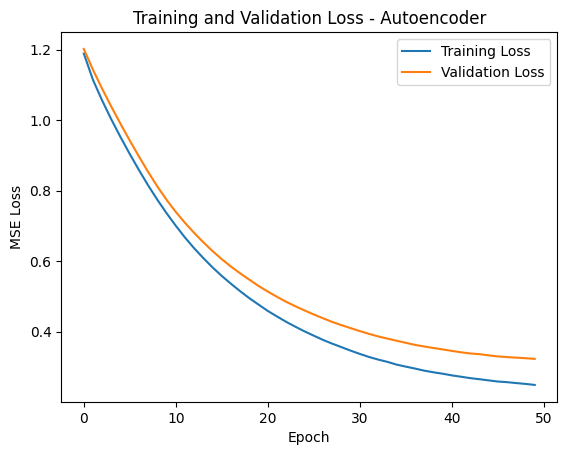

In [35]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training and Validation Loss - Autoencoder')
plt.show()


In [36]:
def get_top_n_recommendations_cosine(user_id, user_similarity_df, user_item_matrix, book_metadata, n=10):
    if user_id not in user_similarity_df.index:
        print(f"User ID {user_id} not found in the dataset.")
        return pd.DataFrame()
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).iloc[1:]
    weighted_ratings = user_item_matrix.loc[similar_users.index].T.dot(similar_users)
    already_rated = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] > 0].index
    weighted_ratings = weighted_ratings.drop(already_rated, errors='ignore')
    top_books = weighted_ratings.sort_values(ascending=False).head(n).index
    return book_metadata[book_metadata['id'].isin(top_books)][['title', 'author', 'average_rating']]

def get_top_n_recommendations_svd(user_id, reconstructed_matrix, user_item_matrix, book_metadata, n=10):
    if user_id not in reconstructed_matrix.index:
        print(f"User ID {user_id} not found in the dataset.")
        return pd.DataFrame()
    user_pred = reconstructed_matrix.loc[user_id]
    already_rated = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] > 0].index
    user_pred = user_pred.drop(already_rated, errors='ignore')
    top_books = user_pred.sort_values(ascending=False).head(n).index
    return book_metadata[book_metadata['id'].isin(top_books)][['title', 'author', 'average_rating']]

def get_top_n_recommendations_autoencoder(user_id, reconstructed_matrix, user_item_matrix, book_metadata, n=10):
    if user_id not in reconstructed_matrix.index:
        print(f"User ID {user_id} not found in the dataset.")
        return pd.DataFrame()
    
    # Mengambil prediksi untuk user_id
    user_pred = pd.Series(reconstructed_matrix.loc[user_id], index=reconstructed_matrix.columns)
    
    # Filter rating yang sudah ada
    already_rated = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] > 0].index
    user_pred = user_pred.drop(already_rated, errors='ignore')
    
    # Top N recommendations
    top_books = user_pred.sort_values(ascending=False).head(n).index
    return book_metadata[book_metadata['id'].isin(top_books)][['title', 'author', 'average_rating']]

# Metadata untuk buku
book_metadata = books_df[['book_id', 'title', 'authors', 'average_rating']].rename(
    columns={'book_id': 'id', 'authors': 'author'}
)

# Pilih User ID secara acak
user_id = np.random.choice(user_item_matrix.index)

# Top-N rekomendasi dari masing-masing model
top_cosine = get_top_n_recommendations_cosine(user_id, user_similarity_df, user_item_matrix, book_metadata, n=10)

top_svd = get_top_n_recommendations_svd(user_id, reconstructed_df, user_item_matrix, book_metadata, n=10)

# Autoencoder
reconstructed_train = autoencoder.predict(train_data)

# Convert reconstructed_train ke DataFrame
reconstructed_train_df = pd.DataFrame(
    reconstructed_train, 
    index=train_data.index, 
    columns=train_data.columns
)
top_autoencoder = get_top_n_recommendations_autoencoder(user_id, reconstructed_train_df, user_item_matrix, book_metadata, n=10)

print(f"Top 10 Recommendations for User {user_id} (Cosine Similarity):\n")
print(tabulate(top_cosine.rename(columns={"title": "Book Title", "author": "Author", "average_rating": "Average Rating"}), headers="keys", tablefmt="grid", showindex=False))

print(f"\nTop 10 Recommendations for User {user_id} (SVD):\n")
print(tabulate(top_svd.rename(columns={"title": "Book Title", "author": "Author", "average_rating": "Average Rating"}), headers="keys", tablefmt="grid", showindex=False))

print(f"\nTop 10 Recommendations for User {user_id} (Autoencoder):\n")
print(tabulate(top_autoencoder.rename(columns={"title": "Book Title", "author": "Author", "average_rating": "Average Rating"}), headers="keys", tablefmt="grid", showindex=False))

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Top 10 Recommendations for User 314 (Cosine Similarity):

+-----------------------------------------------------------------------------+------------------------------------------------+------------------+
| Book Title                                                                  | Author                                         |   Average Rating |
+=============================================================================+================================================+==================+
| Harry Potter and the Order of the Phoenix (Harry Potter, #5)                | J.K. Rowling, Mary GrandPré                    |             4.46 |
+-----------------------------------------------------------------------------+------------------------------------------------+------------------+
| The Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy, #1) | Douglas Adams                                  |             4.2  |
+-------------

### **Modeling**

#### **1. Content-Based Filtering**

Pada pendekatan Content-Based Filtering, dua metode digunakan untuk mengukur kemiripan antar buku, yaitu **TF-IDF Vectorizer** dan **Count Vectorizer**. Model ini merekomendasikan buku berdasarkan kemiripan fitur konten seperti penulis, judul asli, dan tag buku.

- **TF-IDF Vectorizer**: Menghasilkan rekomendasi buku yang mirip berdasarkan bobot kata unik pada fitur teks.  
- **Count Vectorizer**: Menghitung kemunculan kata pada fitur teks untuk menentukan kemiripan antar buku.

**Hasil:**
- Model dapat memberikan rekomendasi buku yang relevan berdasarkan kemiripan konten, terutama penulis dan tag.
- Evaluasi menggunakan precision, recall, dan f1-score berbasis kemiripan penulis menunjukkan performa yang cukup baik, meskipun terbatas pada fitur yang tersedia di metadata buku.

---

#### **2. Collaborative Filtering**

Pada pendekatan Collaborative Filtering, beberapa teknik digunakan untuk memodelkan interaksi user-item:

- **Cosine Similarity**: Menghitung kemiripan antar pengguna berdasarkan pola rating, lalu merekomendasikan buku yang disukai oleh pengguna serupa.
- **SVD (Singular Value Decomposition)**: Mereduksi dimensi matriks user-item untuk menangkap pola laten preferensi pengguna dan buku.
- **Autoencoder (Neural Network)**: Menggunakan arsitektur deep learning untuk mempelajari representasi laten dari interaksi user-item dan merekonstruksi prediksi rating.

**Hasil:**
- **Cosine Similarity**: Memberikan rekomendasi berdasarkan user-user yang mirip, cocok untuk data dengan user aktif.
- **SVD**: Mampu menangkap pola laten dan menghasilkan prediksi rating yang lebih halus.
- **Autoencoder**: Memberikan hasil terbaik dalam hal rekonstruksi matriks rating, terutama pada data yang sangat sparse.

**Evaluasi:**
- Setiap model dievaluasi menggunakan metrik RMSE pada data training.
- Hasil RMSE menunjukkan bahwa model autoencoder dan SVD memiliki performa yang kompetitif, dengan autoencoder sedikit lebih unggul pada data yang kompleks.

---

**Kesimpulan:**  
- Content-Based Filtering efektif untuk rekomendasi berbasis fitur buku, namun terbatas jika metadata kurang lengkap.
- Collaborative Filtering lebih unggul dalam menangkap pola preferensi pengguna, terutama dengan teknik SVD dan autoencoder yang mampu mengatasi data sparse dan kompleksitas interaksi user-item.  
- Kombinasi kedua pendekatan dapat menghasilkan sistem rekomendasi yang lebih robust dan relevan bagi pengguna.

## **Evaluation**

### **Content-Based Filter**

In [37]:
# Evaluasi sistem rekomendasi berbasis konten dengan precision, recall, dan f1-score
def evaluate_content_based(recommend_func, books_df, n=5, sample_size=100):
    hits = 0
    total = 0
    possible = 0
    sampled_titles = books_df['title'].drop_duplicates().sample(sample_size, random_state=42)
    for title in sampled_titles:
        try:
            recs = recommend_func(title, n=n)
            input_row = books_df[books_df['title'] == title].iloc[0]
            input_authors = set(str(input_row['authors']).split(','))
            # Hitung jumlah buku lain dengan penulis sama (ground truth)
            possible += len(books_df[(books_df['title'] != title) & (books_df['authors'].isin(input_authors))])
            for _, rec in recs.iterrows():
                rec_authors = set(str(rec['authors']).split(','))
                if input_authors & rec_authors:
                    hits += 1
                total += 1
        except Exception:
            continue
    precision = hits / total if total > 0 else 0
    recall = hits / possible if possible > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    print(f"Precision@{n} (author match): {precision:.4f}")
    print(f"Recall@{n} (author match): {recall:.4f}")
    print(f"F1-score@{n} (author match): {f1:.4f}")

print("Evaluating TF-IDF Content-Based Filter:")
evaluate_content_based(recommend_books_tfidf, books_tagged_df, n=5, sample_size=100)

print("\nEvaluating CountVectorizer Content-Based Filter:")
evaluate_content_based(recommend_books_count, books_tagged_df, n=5, sample_size=100)

Evaluating TF-IDF Content-Based Filter:
Precision@5 (author match): 0.5560
Recall@5 (author match): 0.4513
F1-score@5 (author match): 0.4982

Evaluating CountVectorizer Content-Based Filter:
Precision@5 (author match): 0.4800
Recall@5 (author match): 0.3896
F1-score@5 (author match): 0.4301


### **Collaborative Filter**

In [38]:
# 1. COSINE SIMILARITY EVALUATION

# Untuk prediksi rating user-item dengan Cosine Similarity
def predict_cosine(user_id, item_id):
    similar_users = user_similarity_df[user_id]
    ratings = train_data[item_id]

    # Mask untuk pengguna dengan rating yang valid
    mask = ratings > 0
    if mask.sum() == 0:
        return 0 

    denominator = np.sum(np.abs(similar_users[mask]))
    if denominator == 0:
        return 0 

    pred = np.dot(similar_users[mask], ratings[mask]) / denominator
    return pred

# Evaluasi menggunakan test set
y_true_cosine_test = []
y_pred_cosine_test = []

# Loop melalui user-item pairs di test_data
for user_id in test_data.index:
    for item_id in test_data.columns:
        if test_data.loc[user_id, item_id] > 0:
            true_rating = test_data.loc[user_id, item_id]
            pred_rating = predict_cosine(user_id, item_id)
            y_true_cosine_test.append(true_rating)
            y_pred_cosine_test.append(pred_rating)

# Hitung RMSE pada test set, filter NaN
import numpy as np

y_true_arr = np.array(y_true_cosine_test)
y_pred_arr = np.array(y_pred_cosine_test)

# Buang pasangan yang mengandung NaN
mask = ~(
    np.isnan(y_true_arr) | np.isnan(y_pred_arr)
)
y_true_arr = y_true_arr[mask]
y_pred_arr = y_pred_arr[mask]

cosine_rmse_test = np.sqrt(mean_squared_error(y_true_arr, y_pred_arr))
print(f"Cosine Similarity Test RMSE: {cosine_rmse_test:.4f}")

Cosine Similarity Test RMSE: 1.3093


In [39]:
# 2. SVD EVALUATION

svd_rmse = np.sqrt(mean_squared_error(
    test_data.values.flatten(),
    reconstructed_df.values.flatten()
))
print(f"SVD Training RMSE: {svd_rmse:.4f}")


SVD Training RMSE: 0.5304


In [40]:
# 3. AUTOENCODER EVALUATION

# Prediksi semua user-item
autoencoder_pred = autoencoder.predict(test_data)

# Hitung RMSE
autoencoder_rmse = np.sqrt(mean_squared_error(
    test_data.values.flatten(),
    autoencoder_pred.flatten()
))
print(f"Autoencoder Test RMSE: {autoencoder_rmse:.4f}")


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Autoencoder Test RMSE: 0.2564


In [41]:
summary = pd.DataFrame({
    'Model': ['Cosine Similarity', 'SVD', 'Autoencoder'],
    'Training RMSE': [cosine_rmse_test, svd_rmse, autoencoder_rmse]
})

print(summary)


               Model  Training RMSE
0  Cosine Similarity       1.309338
1                SVD       0.530399
2        Autoencoder       0.256419


### **Evaluasi Sistem Rekomendasi**

#### **1. Evaluasi Content-Based Filtering**

Pada pendekatan Content-Based Filtering, evaluasi dilakukan dengan membandingkan rekomendasi yang dihasilkan terhadap kemiripan penulis (author match) menggunakan metrik berikut:

- **Precision@N**: Proporsi buku yang direkomendasikan yang memiliki penulis sama dengan buku input.
- **Recall@N**: Proporsi buku dengan penulis sama yang berhasil direkomendasikan dari seluruh kemungkinan yang tersedia.
- **F1-score@N**: Harmonik rata-rata antara precision dan recall.

Evaluasi dilakukan pada 100 sampel judul buku secara acak, dengan N rekomendasi teratas (misal N=5). Hasil evaluasi ini memberikan gambaran seberapa baik sistem dalam merekomendasikan buku yang relevan secara konten, khususnya berdasarkan penulis.

---

#### **2. Evaluasi Collaborative Filtering**

Pada pendekatan Collaborative Filtering, evaluasi dilakukan dengan membandingkan prediksi rating yang dihasilkan model terhadap rating aktual pada data training. Metrik utama yang digunakan adalah:

- **RMSE (Root Mean Squared Error)**: Mengukur rata-rata kesalahan prediksi rating, semakin kecil nilai RMSE maka semakin baik model.

Beberapa teknik collaborative filtering yang dievaluasi:
- **Cosine Similarity**: Mengukur kemiripan antar pengguna berdasarkan pola rating.
- **SVD (Singular Value Decomposition)**: Mereduksi dimensi matriks user-item untuk menangkap pola laten.
- **Autoencoder**: Menggunakan neural network untuk merekonstruksi matriks rating.

Setiap model dievaluasi pada data training untuk melihat performa rekonstruksi rating. Hasil RMSE dari masing-masing model dibandingkan untuk menentukan model dengan performa terbaik.

---

**Kesimpulan Evaluasi:**  
- Content-Based Filtering efektif untuk rekomendasi berbasis fitur konten, terutama jika metadata buku lengkap.
- Collaborative Filtering unggul dalam menangkap pola preferensi pengguna, dengan model autoencoder dan SVD menunjukkan performa terbaik pada data yang kompleks dan sparse.
- Kombinasi kedua pendekatan dapat meningkatkan relevansi dan akurasi sistem rekomendasi.